<a href="https://colab.research.google.com/github/AyishaR/Spokendigit/blob/master/Spokendigit_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import tarfile
import os
from torch.utils.data import Dataset
from torchvision.datasets.utils import download_url
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import sklearn
import matplotlib
import csv
from PIL import Image

#Data

In [ ]:
data = download_url("http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz", "/content/")

with tarfile.open('/content/speech_commands_v0.01.tar.gz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
data, sampling_rate = librosa.load('/content/data/one/00176480_nohash_0.wav')
data, data.shape, sampling_rate

(array([-2.9995823e-05, -1.6769719e-04, -3.9024639e-04, ...,
        -6.1316596e-04, -3.3654648e-04, -1.7320579e-04], dtype=float32),
 (22050,),
 22050)

In [ ]:
digit = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
for x in digit:
    print(x, ": ", len(os.listdir('/content/data/'+x)))

#Balanced

zero :  2376
one :  2370
two :  2373
three :  2356
four :  2372
five :  2357
six :  2369
seven :  2377
eight :  2352
nine :  2364


#Analysis

Visulaization and understanding the extracted features

In [ ]:
class SpokenDigit(Dataset):
    def __init__(self, file = None, fdata = None, rootdir = None):
        if fdata:
            self.df = pd.DataFrame(fdata)
        else:
            self.df = pd.read_csv(file)
        self.rootdir = rootdir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.loc[i]
        if self.df.shape[1] == 1:
            fname = row[0]
            data, _ = librosa.load(self.rootdir+'/'+fname)
            return torch.Tensor(data)
        else:
            fname, label = row['File'], row['Label']
            data, _ = librosa.load(self.rootdir+'/'+fname)
            return torch.Tensor(data), label
    
    def getsr(self, i):
        row = self.df.loc[i]
        if self.df.shape[1] == 1:
            fname = row[0]
        else:
            fname, label = row['File'], row['Label']
        _, sr = librosa.load(self.rootdir+'/'+fname)
        return sr

Spoken_digit.csv is generated in 'Spokendigit feature extraction.ipynb'.

In [ ]:
dataset = SpokenDigit(file = 'Spoken_digit.csv', rootdir = '/content/data/')

In [ ]:
import IPython.display as ipd
for i in range(5):
    ipath = '/content/data/'+dataset.df.loc[i]['File']
    id = librosa.load(ipath)
    print(ipath)
    _, ilabel = dataset[i]
    print(decode(ilabel))
    ipd.Audio(data = id[0], rate = id[1])

#If a filename or url is used, the format support will be browser dependent.

In [ ]:
def view(data, label):
    plt.figure(figsize=(12, 4))
    plt.title(label)
    librosa.display.waveplot(np.array(data), sr=data.shape[0])

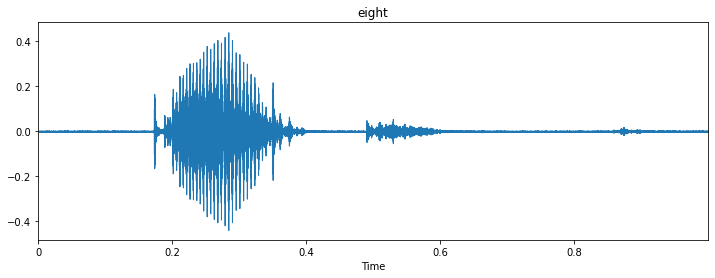

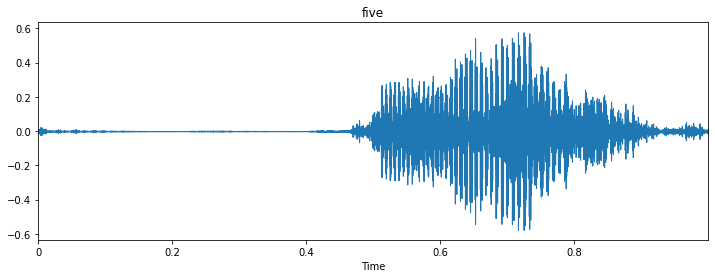

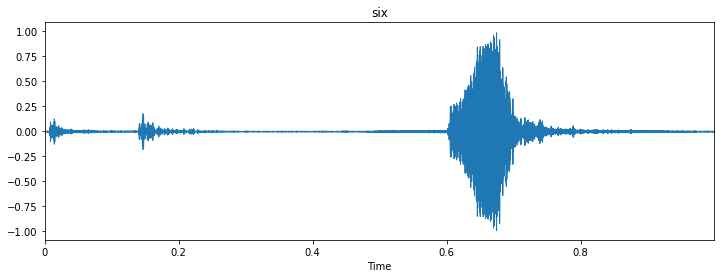

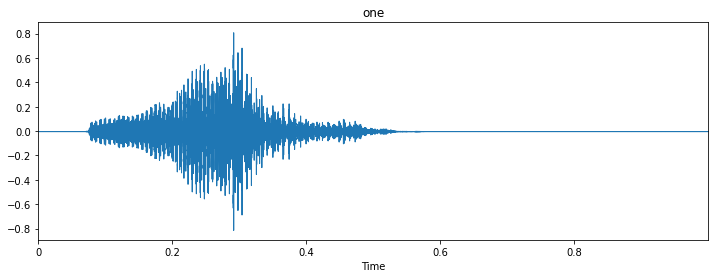

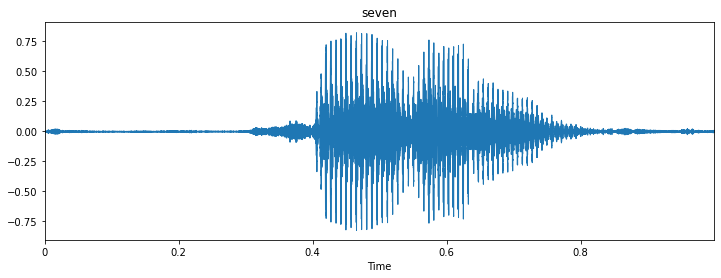

In [ ]:
for i in range(5):
    view(*dataset[i])

Examples of each digit are picked to visualize features. For this, Spoken_digit_X.csv generaated in 'Spokendigit feature extraction.ipynb' can be used, or a dataset can be created for each label group as follows.

In [ ]:
d = {}
for x in digit:
    if os.path.isdir('/content/data/'+x):
        d[x] = os.listdir('/content/data/'+x)

In [ ]:
digitx = [None]*10
for i in range(10):
    digitx[i] = SpokenDigit(fdata = d[digit[i]], rootdir= '/content/data/'+digit[i]+'/')

Each row of the below visualizations has plots for 2 individual instances of data for each digit 0-9.



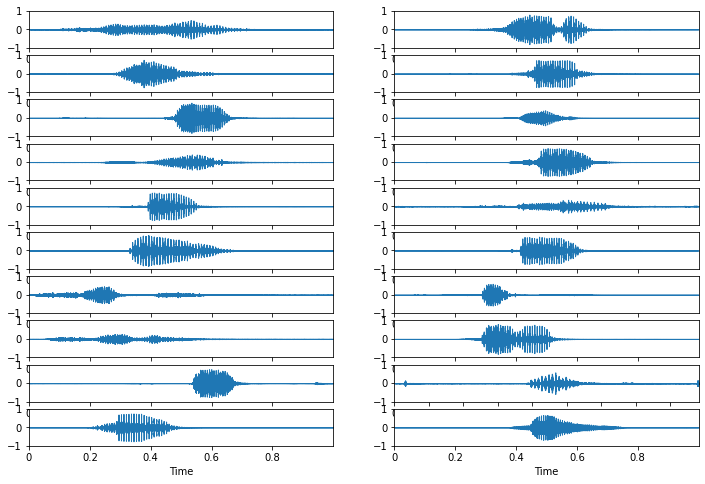

In [ ]:
plts, axs = plt.subplots(10,2)
plts.set_figheight(8)
plts.set_figwidth(12)
for i in range(10):
    for j in range(2):
        axs[i][j].set_ylim([-1, 1])
        librosa.display.waveplot(np.array(digitx[i][j]), sr=digitx[i].getsr(j), ax = axs[i][j])

### Mfccs plot

Rows: Digit 0-9

Column 1, 2: Plot of MFCCs and standardized MFCCs of data instance 1.

Column 3, 4: Plot of MFCCs and standardized MFCCs of data instance 2.

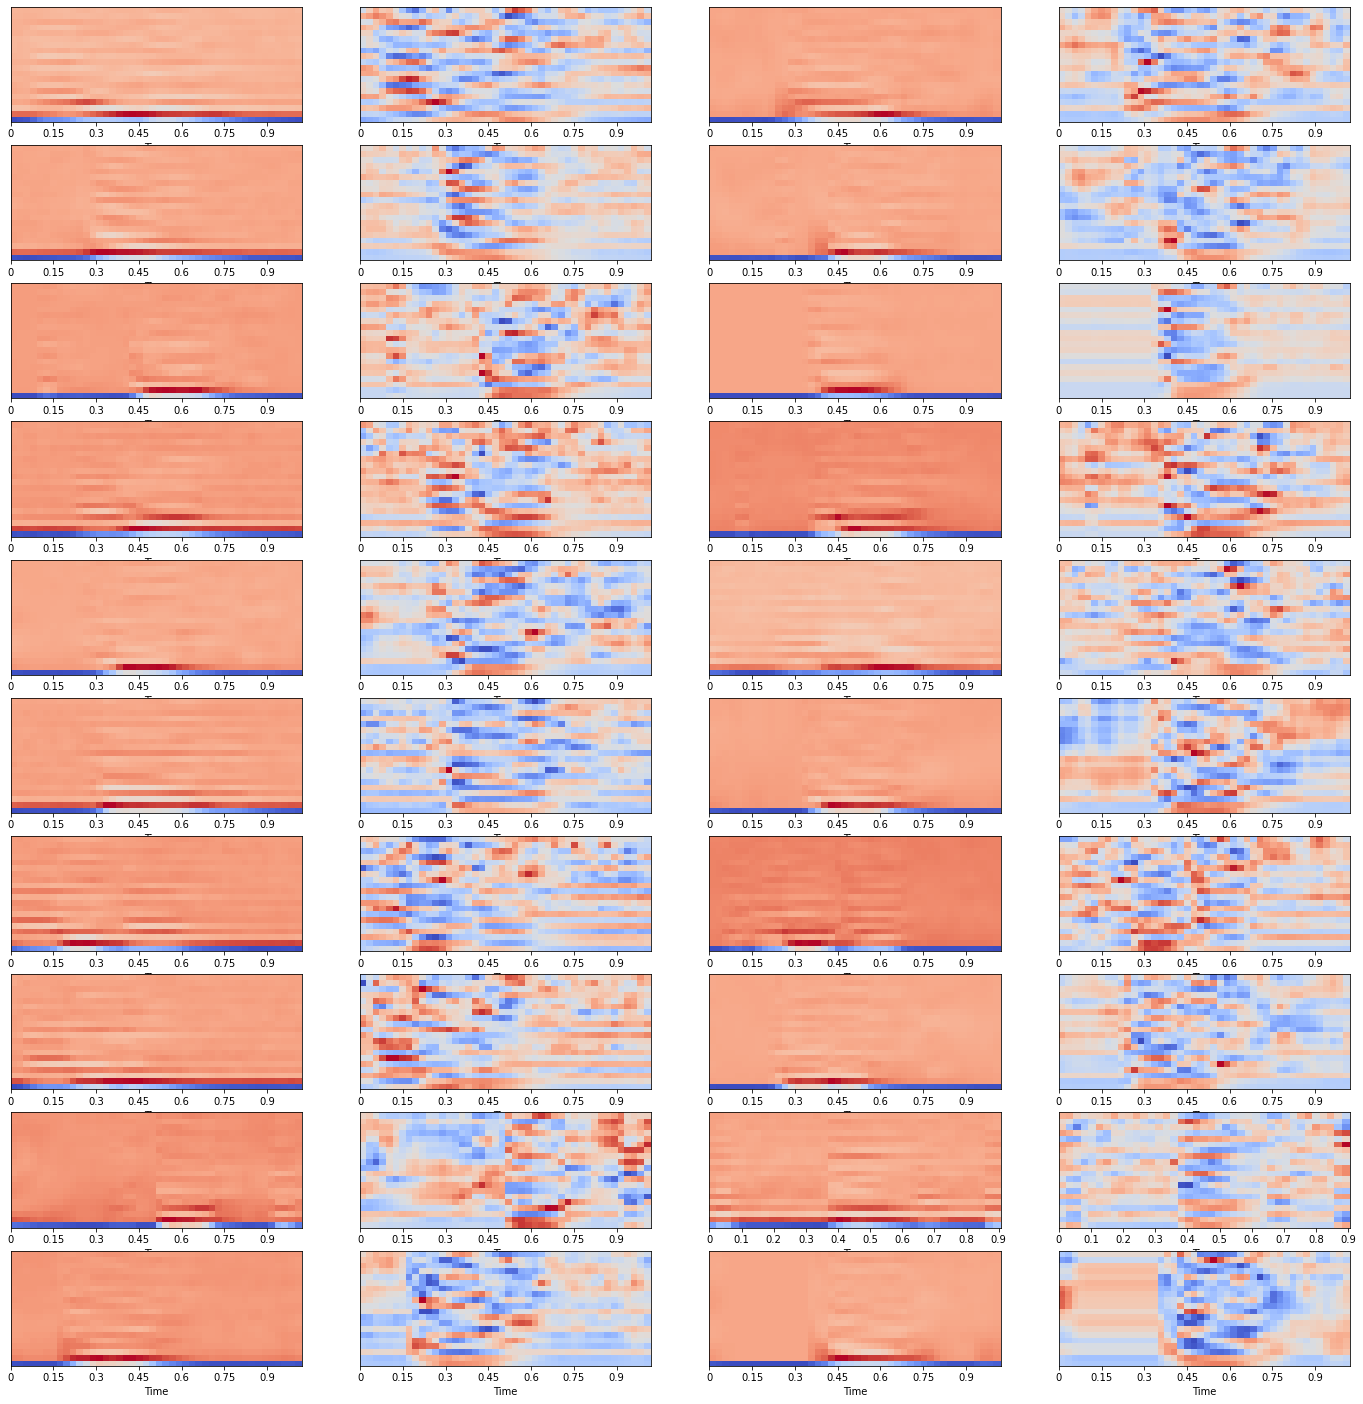

In [ ]:
#mfcc
plts, axs = plt.subplots(10,4)
plts.set_figheight(25)
plts.set_figwidth(24)
for i in range(10): 
    for j in range(2):
        mfccs = librosa.feature.mfcc(np.array(digitx[i][j]), sr=digitx[i].getsr(j))
        librosa.display.specshow(mfccs, sr=digitx[i].getsr(j), x_axis='time', ax=axs[i][2*j])
        mfccs = sklearn.preprocessing.scale(mfccs, axis = 1)
        librosa.display.specshow(mfccs, sr=digitx[i].getsr(j), x_axis='time', ax=axs[i][2*j+1])

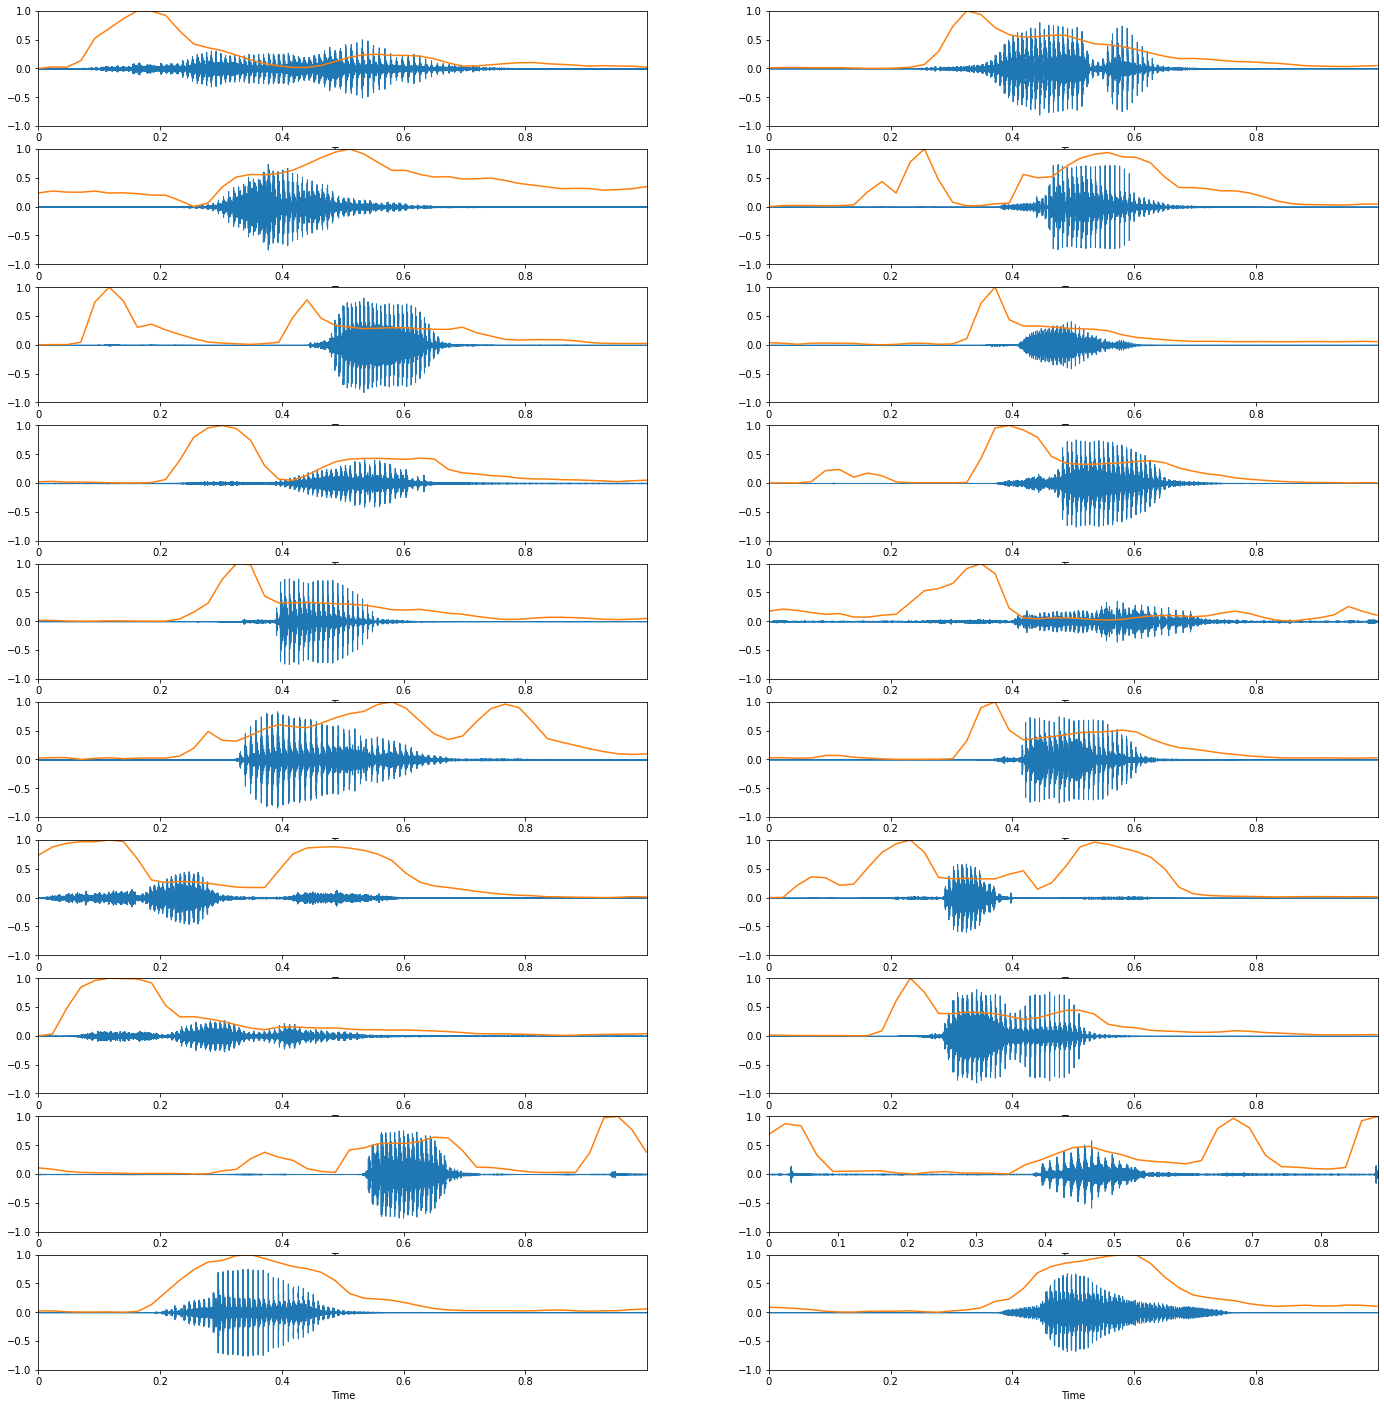

In [ ]:
#spectral centroids
plts, axs = plt.subplots(10,2)
plts.set_figheight(25)
plts.set_figwidth(24)
for i in range(10): 
    for j in range(2):
        axs[i][j].set_ylim([-1,1])
        spectral_centroids = librosa.feature.spectral_centroid(np.array(digitx[i][j])+0.01, sr=digitx[i].getsr(j))[0]
        # silence may cause high frequency to dominate
        spectral_centroids = sklearn.preprocessing.minmax_scale(spectral_centroids)
        t = librosa.frames_to_time(range(len(spectral_centroids)))
        librosa.display.waveplot(np.array(digitx[i][j]), sr=digitx[i].getsr(j), ax = axs[i][j])
        plt.subplot(axs[i][j])
        plt.plot(t, spectral_centroids)

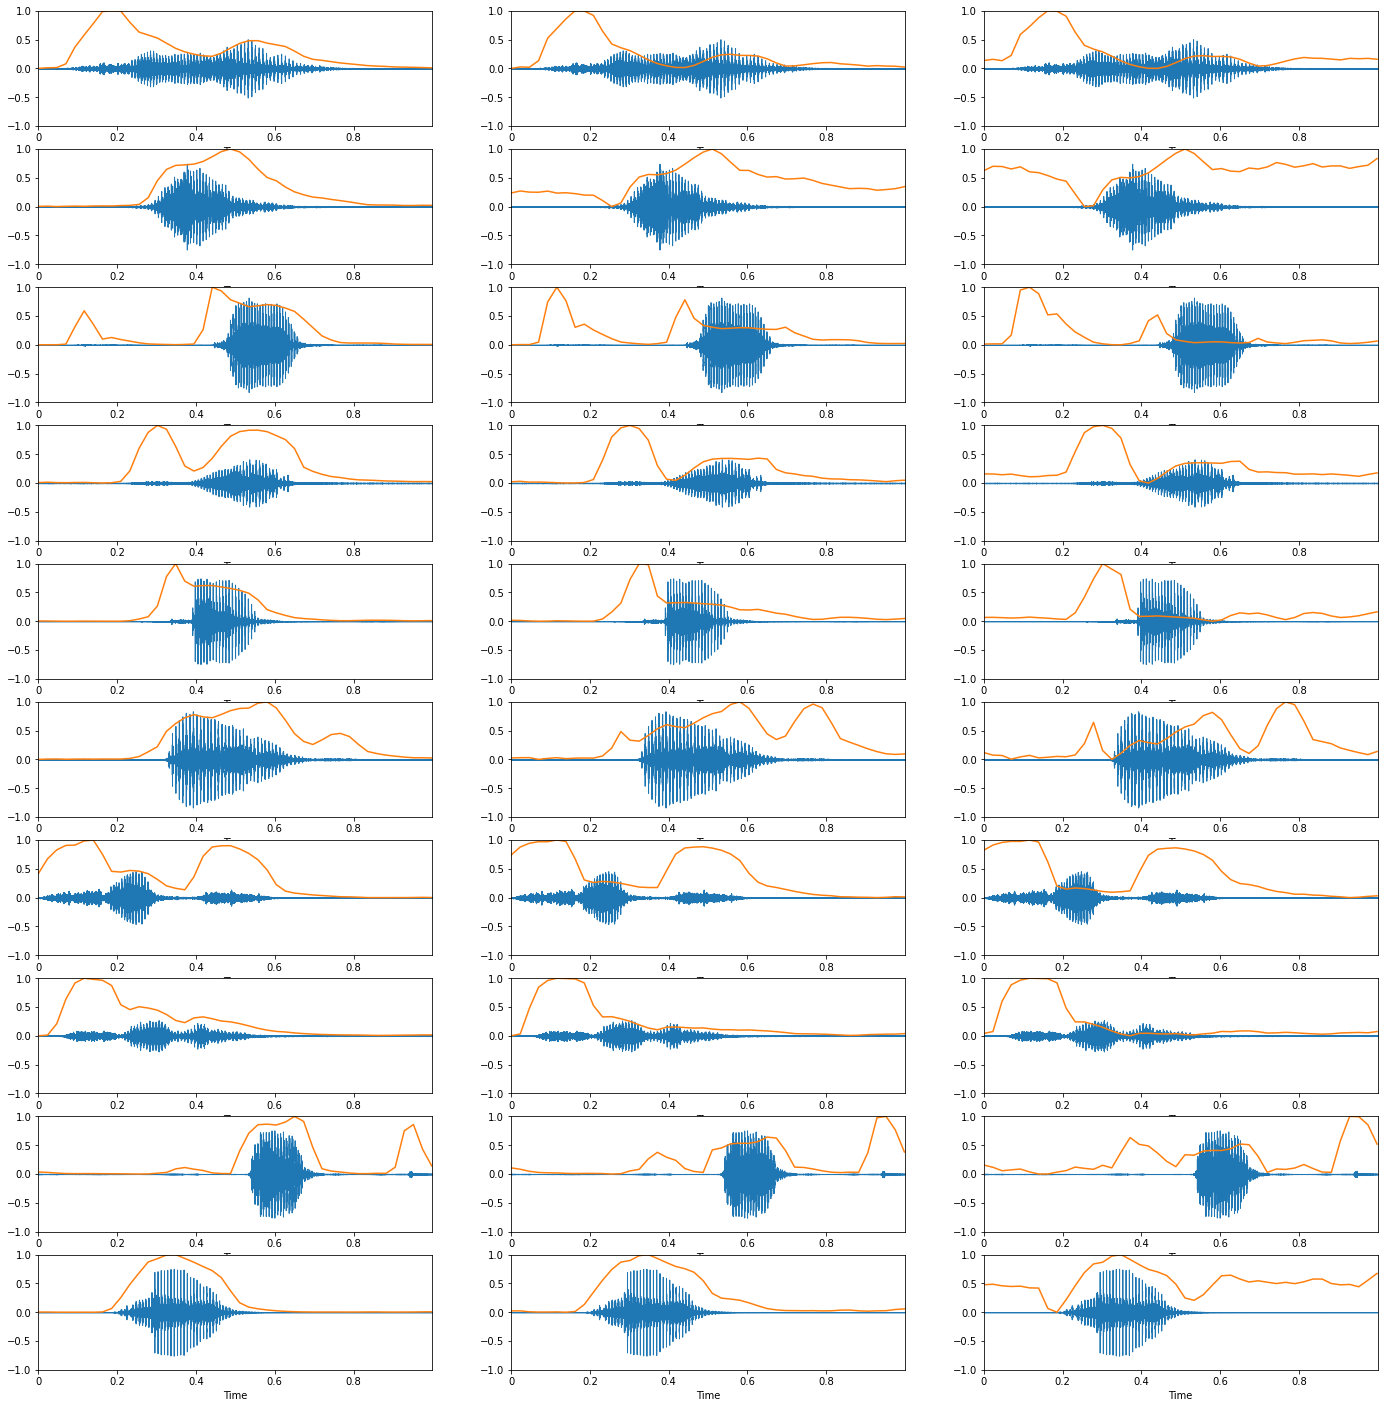

In [ ]:
#spectral centroids - varying the constant (0.1, 0.01, 0.001) added to the data to avoid miscalculations due to silence
plts, axs = plt.subplots(10,3)
plts.set_figheight(25)
plts.set_figwidth(24)
for i in range(10): 
    for j in range(3):
        axs[i][j].set_ylim([-1,1])
        spectral_centroids = librosa.feature.spectral_centroid(np.array(digitx[i][0])+(1/10**(j+1)), sr=digitx[i].getsr(0))[0]
        # silence may cause high frequency to dominate
        spectral_centroids = sklearn.preprocessing.minmax_scale(spectral_centroids)
        t = librosa.frames_to_time(range(len(spectral_centroids)))
        librosa.display.waveplot(np.array(digitx[i][0]), sr=digitx[i].getsr(0), ax = axs[i][j])
        plt.subplot(axs[i][j])
        plt.plot(t, spectral_centroids)

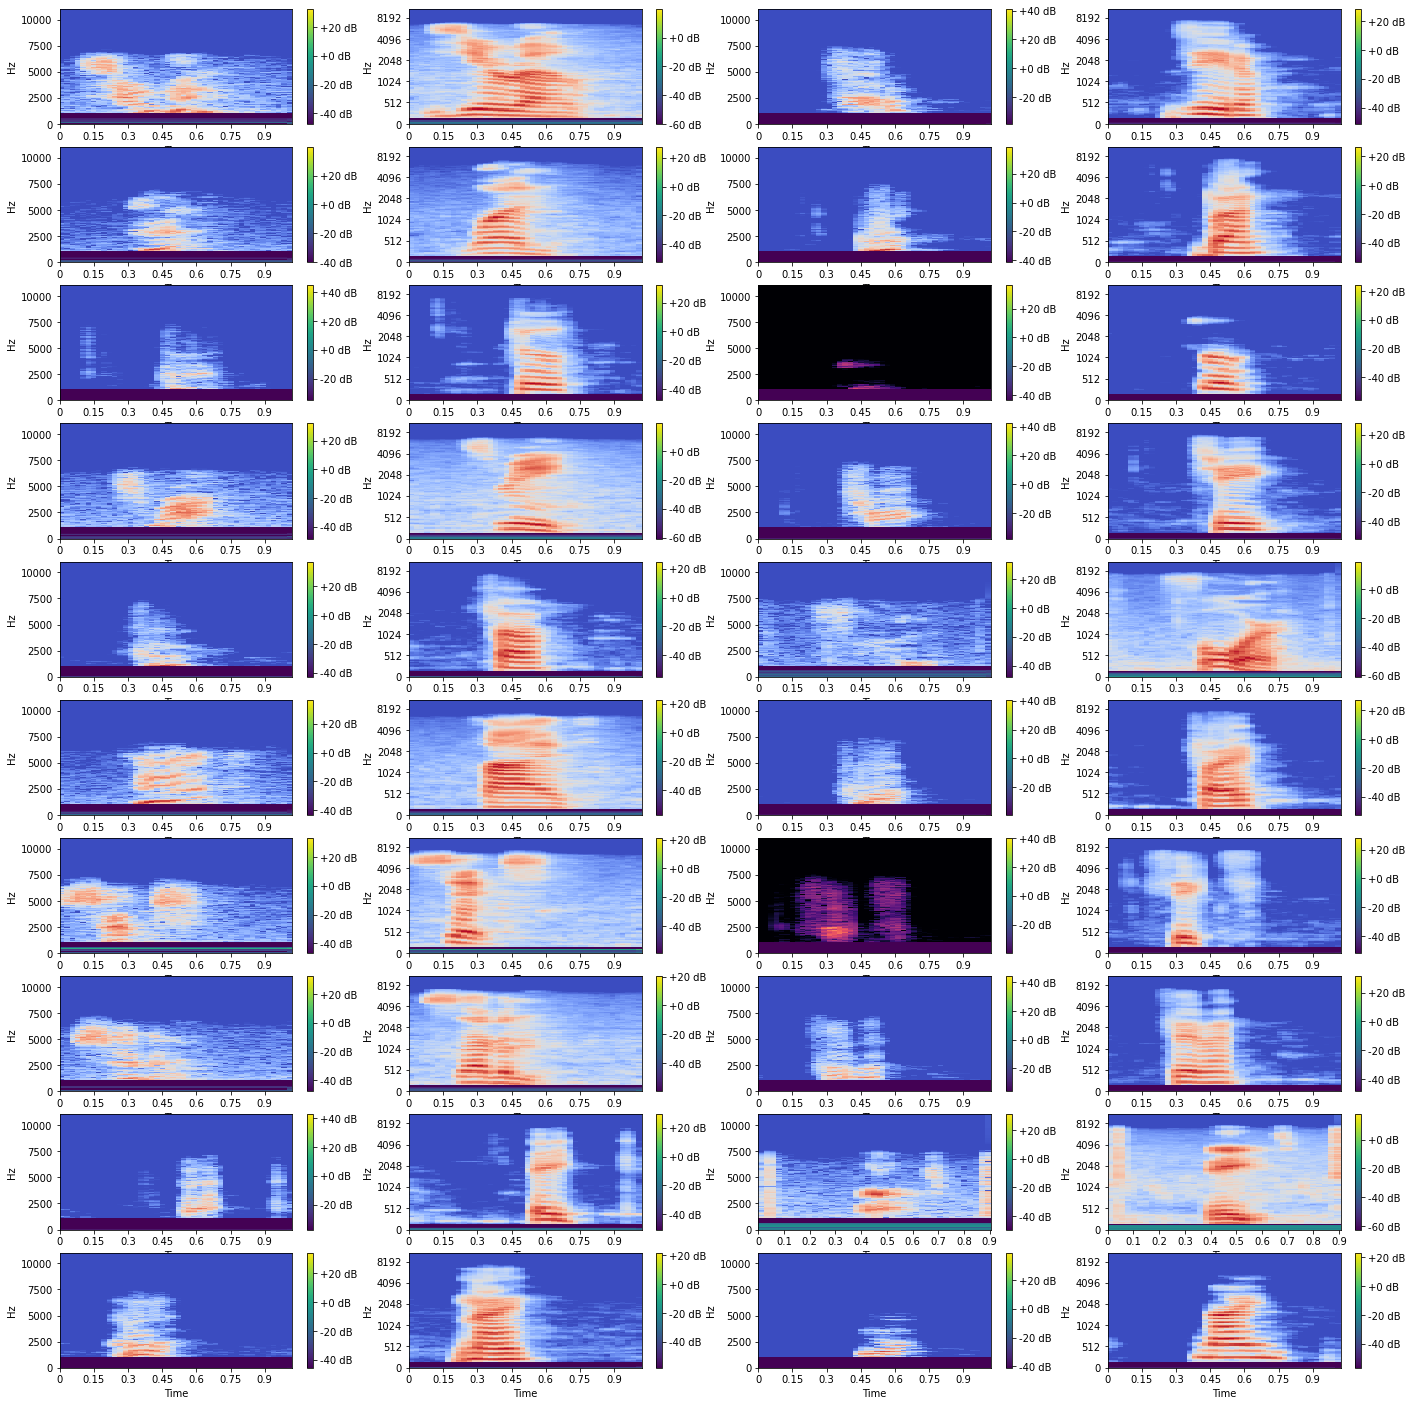

In [ ]:
hop = 512
n_fft = 2048

plts, axs = plt.subplots(10,4)
plts.set_figheight(25)
plts.set_figwidth(24)
for i in range(10): 
    for j in range(2):
        #spectogram - column 1, 3
        X = librosa.stft(np.array(digitx[i][j]), n_fft=n_fft, hop_length=hop)
        S = librosa.amplitude_to_db(abs(X))
        librosa.display.specshow(S, sr=digitx[i].getsr(j), hop_length=hop, x_axis='time', y_axis='linear', ax=axs[i][2*j])
        plt.subplot(axs[i][2*j])
        pcm = axs[i][2*j].pcolormesh(S)
        plt.colorbar(pcm, ax = axs[i][2*j], format='%+2.0f dB')

        #melspectogram - column 2, 4
        S = librosa.feature.melspectrogram(np.array(digitx[i][j]), sr=digitx[i].getsr(j), n_fft=n_fft, hop_length=hop)
        logS = librosa.power_to_db(abs(S))
        librosa.display.specshow(logS, sr=digitx[i].getsr(j), hop_length=hop, x_axis='time', y_axis='mel', ax = axs[i][2*j+1])
        plt.subplot(axs[i][2*j+1])
        pcm = axs[i][2*j+1].pcolormesh(logS)
        plt.colorbar(pcm, ax = axs[i][2*j+1], format='%+2.0f dB')